In [1]:
import requests
import zipfile
import re
import shap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import snowflake.snowpark.functions as F
from snowflake.snowpark import Session
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import Registry
from snowflake.ml._internal.utils import identifier

sns.set(style="whitegrid")

/opt/homebrew/Caskroom/miniconda/base/envs/snowpark-ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data into snowflake

In [2]:
options = SnowflakeLoginOptions(login_file=".snowsql/config", connection_name="ml")

sp_session = Session.builder.configs(options).create()

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


In [3]:
def download_dataset(url, file_name):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, 'wb') as file:
            file.write(response.content)
        print(f"Dataset downloaded and saved as {file_name}.")
    else:
        print(f"Failed to download dataset. HTTP status code: {response.status_code}")

dataset_url = "https://archive.ics.uci.edu/static/public/9/auto+mpg.zip"
zip_file_name = "cars.zip"
download_dataset(dataset_url, zip_file_name)

Dataset downloaded and saved as cars.zip.


In [4]:
stage_name = "auto_mpg_stage"
table_name = "auto_mpg"

sp_session.sql(f"CREATE OR REPLACE STAGE {stage_name};").show()

---------------------------------------------------
|"status"                                         |
---------------------------------------------------
|Stage area AUTO_MPG_STAGE successfully created.  |
---------------------------------------------------



In [5]:
file_name = "auto-mpg.data"

def put_zip_file_to_sf(zip_name, file_name, stage_name):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall("temp_dir")

        with open("temp_dir/auto-mpg.data", "r") as file:
            data = file.read()
        cleaned_data = re.sub(r'[ \t]+', ',', data)
        with open(f"temp_dir/cleaned-{file_name}", "w") as file:
            file.write(cleaned_data)

        sp_session.file.put(f"temp_dir/cleaned-{file_name}", f"@{stage_name}", auto_compress=False)
        sp_session.file.put(f"temp_dir/{file_name}", f"@{stage_name}", auto_compress=False)
    print(f"Uploaded {file_name} to stage and its cleaned version.")

put_zip_file_to_sf(zip_file_name, file_name, stage_name)

Uploaded auto-mpg.data to stage and its cleaned version.


In [6]:
sp_session.sql(f"LIST @{stage_name};").show()

-------------------------------------------------------------------------------------------------------------------
|"name"                                |"size"  |"md5"                             |"last_modified"               |
-------------------------------------------------------------------------------------------------------------------
|auto_mpg_stage/auto-mpg.data          |30288   |7101a6f5f22d689364c51ce2df712f4a  |Sat, 4 Jan 2025 20:03:21 GMT  |
|auto_mpg_stage/cleaned-auto-mpg.data  |21504   |687baf58420c8fb2be0dac62dff384e7  |Sat, 4 Jan 2025 20:03:20 GMT  |
-------------------------------------------------------------------------------------------------------------------



In [7]:
sp_session.sql(f"""
    CREATE OR REPLACE TABLE {table_name} (
        id INT IDENTITY(1, 1),
        mpg FLOAT,
        cylinders INT,
        displacement FLOAT,
        horsepower FLOAT,
        weight FLOAT,
        acceleration FLOAT,
        model_year INT,
        origin INT,
        car_name STRING
    )
""").show()

----------------------------------------
|"status"                              |
----------------------------------------
|Table AUTO_MPG successfully created.  |
----------------------------------------



In [8]:
cleaned_file_name = "cleaned-" + file_name

sp_session.sql(f"""
    CREATE OR REPLACE FILE FORMAT my_csv_format
    TYPE = 'CSV'
    FIELD_OPTIONALLY_ENCLOSED_BY = '"'
    NULL_IF = ('?')
""").show()

---------------------------------------------------
|"status"                                         |
---------------------------------------------------
|File format MY_CSV_FORMAT successfully created.  |
---------------------------------------------------



In [10]:
sp_session.sql(f"""
    COPY INTO {table_name} (mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name)
    FROM @{stage_name}/{cleaned_file_name}
    FILE_FORMAT = (FORMAT_NAME = my_csv_format)
""").show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"file"                                |"status"  |"rows_parsed"  |"rows_loaded"  |"error_limit"  |"errors_seen"  |"first_error"  |"first_error_line"  |"first_error_character"  |"first_error_column_name"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|auto_mpg_stage/cleaned-auto-mpg.data  |LOADED    |398            |398            |1              |0              |NULL           |NULL                |NULL                     |NULL                       |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Eda

In [11]:
df = sp_session.table(table_name)

In [12]:
df.limit(5).show()

------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"  |"MPG"  |"CYLINDERS"  |"DISPLACEMENT"  |"HORSEPOWER"  |"WEIGHT"  |"ACCELERATION"  |"MODEL_YEAR"  |"ORIGIN"  |"CAR_NAME"                 |
------------------------------------------------------------------------------------------------------------------------------------------------
|1     |18.0   |8            |307.0           |130.0         |3504.0    |12.0            |70            |1         |chevrolet,chevelle,malibu  |
|2     |15.0   |8            |350.0           |165.0         |3693.0    |11.5            |70            |1         |buick,skylark,320          |
|3     |18.0   |8            |318.0           |150.0         |3436.0    |11.0            |70            |1         |plymouth,satellite         |
|4     |16.0   |8            |304.0           |150.0         |3433.0    |12.0            |70            |1         |amc,rebel,sst 

In [13]:
df.count()

398

In [14]:
df.print_schema()

root
 |-- "ID": LongType() (nullable = True)
 |-- "MPG": DoubleType() (nullable = True)
 |-- "CYLINDERS": LongType() (nullable = True)
 |-- "DISPLACEMENT": DoubleType() (nullable = True)
 |-- "HORSEPOWER": DoubleType() (nullable = True)
 |-- "WEIGHT": DoubleType() (nullable = True)
 |-- "ACCELERATION": DoubleType() (nullable = True)
 |-- "MODEL_YEAR": LongType() (nullable = True)
 |-- "ORIGIN": LongType() (nullable = True)
 |-- "CAR_NAME": StringType() (nullable = True)


In [15]:
df.describe().show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"               |"MPG"               |"CYLINDERS"         |"DISPLACEMENT"      |"HORSEPOWER"        |"WEIGHT"           |"ACCELERATION"      |"MODEL_YEAR"     |"ORIGIN"            |"CAR_NAME"               |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |398.0              |398.0               |398.0               |398.0               |392.0               |398.0              |398.0               |398.0            |398.0               |398                      |
|mean       |199.5              |23.514572864321607  |5.454774            |193.42587939698493  |104.4693

In [16]:
df = df.cache_result()

In [17]:
df.write.mode("overwrite").save_as_table(table_name)

In [18]:
query = []
for col in df.columns:
    query.append(f"SELECT '{col}' as COL_NAME, COUNT(DISTINCT {col}) NO_DISTINCT, LISTAGG(DISTINCT  {col}, ', ') AS VAL_DISTINCT FROM {table_name}")
query = "\nUNION ALL\n".join(query)

result = sp_session.sql(query).show()

-------------------------------------------------------------------------------------
|"COL_NAME"    |"NO_DISTINCT"  |"VAL_DISTINCT"                                      |
-------------------------------------------------------------------------------------
|ID            |398            |1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 18,...  |
|MPG           |129            |18, 15, 16, 14, 24, 22, 27, 25, 10, 11, 9, 28, ...  |
|CYLINDERS     |5              |8, 4, 6, 3, 5                                       |
|DISPLACEMENT  |82             |307, 350, 318, 304, 302, 429, 454, 440, 455, 39...  |
|HORSEPOWER    |93             |130, 165, 150, 140, 198, 215, 225, 190, 97, 85,...  |
|WEIGHT        |351            |3504, 3693, 3436, 3433, 3449, 4341, 4354, 4312,...  |
|ACCELERATION  |95             |12, 11.5, 10.5, 10, 9, 8.5, 9.5, 15.5, 14.5, 20...  |
|MODEL_YEAR    |13             |70, 71, 72, 73, 75, 76, 77, 78, 74, 79, 80, 81, 82  |
|ORIGIN        |3              |1, 3, 2               

In [19]:
df = df.drop("CAR_NAME")

In [20]:
df.print_schema()

root
 |-- "ID": LongType() (nullable = True)
 |-- "MPG": DoubleType() (nullable = True)
 |-- "CYLINDERS": LongType() (nullable = True)
 |-- "DISPLACEMENT": DoubleType() (nullable = True)
 |-- "HORSEPOWER": DoubleType() (nullable = True)
 |-- "WEIGHT": DoubleType() (nullable = True)
 |-- "ACCELERATION": DoubleType() (nullable = True)
 |-- "MODEL_YEAR": LongType() (nullable = True)
 |-- "ORIGIN": LongType() (nullable = True)


In [23]:
results = []


columns = sorted([col for col in df.columns if col != "ID"])
# Compute pairwise correlations
for i, col_1 in enumerate(columns):
    if i + 1 < len(columns):
        for col_2 in columns[i:]:  # Avoid duplicate pairs and self-correlation
            correlation_df = df.select(
                F.lit(col_1).alias("COL_1"),
                F.lit(col_2).alias("COL_2"),
                F.corr(col_1, col_2).alias("CORR")
            )
            results.append(correlation_df)

# Combine results into a single DataFrame
pairwise_correlations_df = results[0]
for correlation_df in results[1:]:
    pairwise_correlations_df = pairwise_correlations_df.union(correlation_df)

# Create or replace the view in Snowflake
pairwise_correlations_df.create_or_replace_view("PAIRWISE_CORRELATIONS_VIEW")

print("View 'PAIRWISE_CORRELATIONS_VIEW' has been created.")
correlations_view_df = sp_session.table("PAIRWISE_CORRELATIONS_VIEW")

View 'PAIRWISE_CORRELATIONS_VIEW' has been created.


In [24]:
correlations_view_df.count()

35

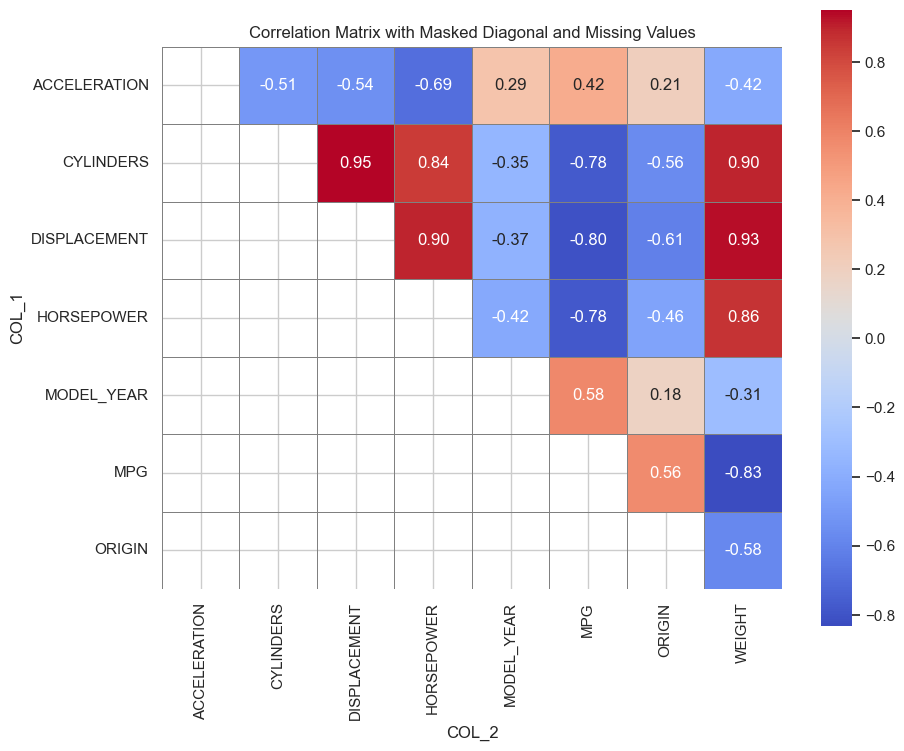

In [25]:
# Query the pairwise correlations view
correlations_df = sp_session.table("PAIRWISE_CORRELATIONS_VIEW").to_pandas()

# Convert the DataFrame to a pivot table (correlation matrix)
correlation_matrix = correlations_df.pivot(index="COL_1", columns="COL_2", values="CORR")

# Create a mask for the upper triangle, diagonal, and missing values
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool), k=0)  # Diagonal and lower triangle masked

# Plot the masked correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask,        # Apply the mask
    annot=True,       # Display correlation values
    fmt=".2f",        # Format for correlation values
    cmap="coolwarm",  # Color map for the heatmap
    square=True,      # Ensure cells are square
    cbar=True,        # Show color bar
    linewidths=0.5,   # Add gridlines for clarity
    linecolor="gray"  # Color of gridlines
)
plt.title("Correlation Matrix with Masked Diagonal and Missing Values")
plt.show()

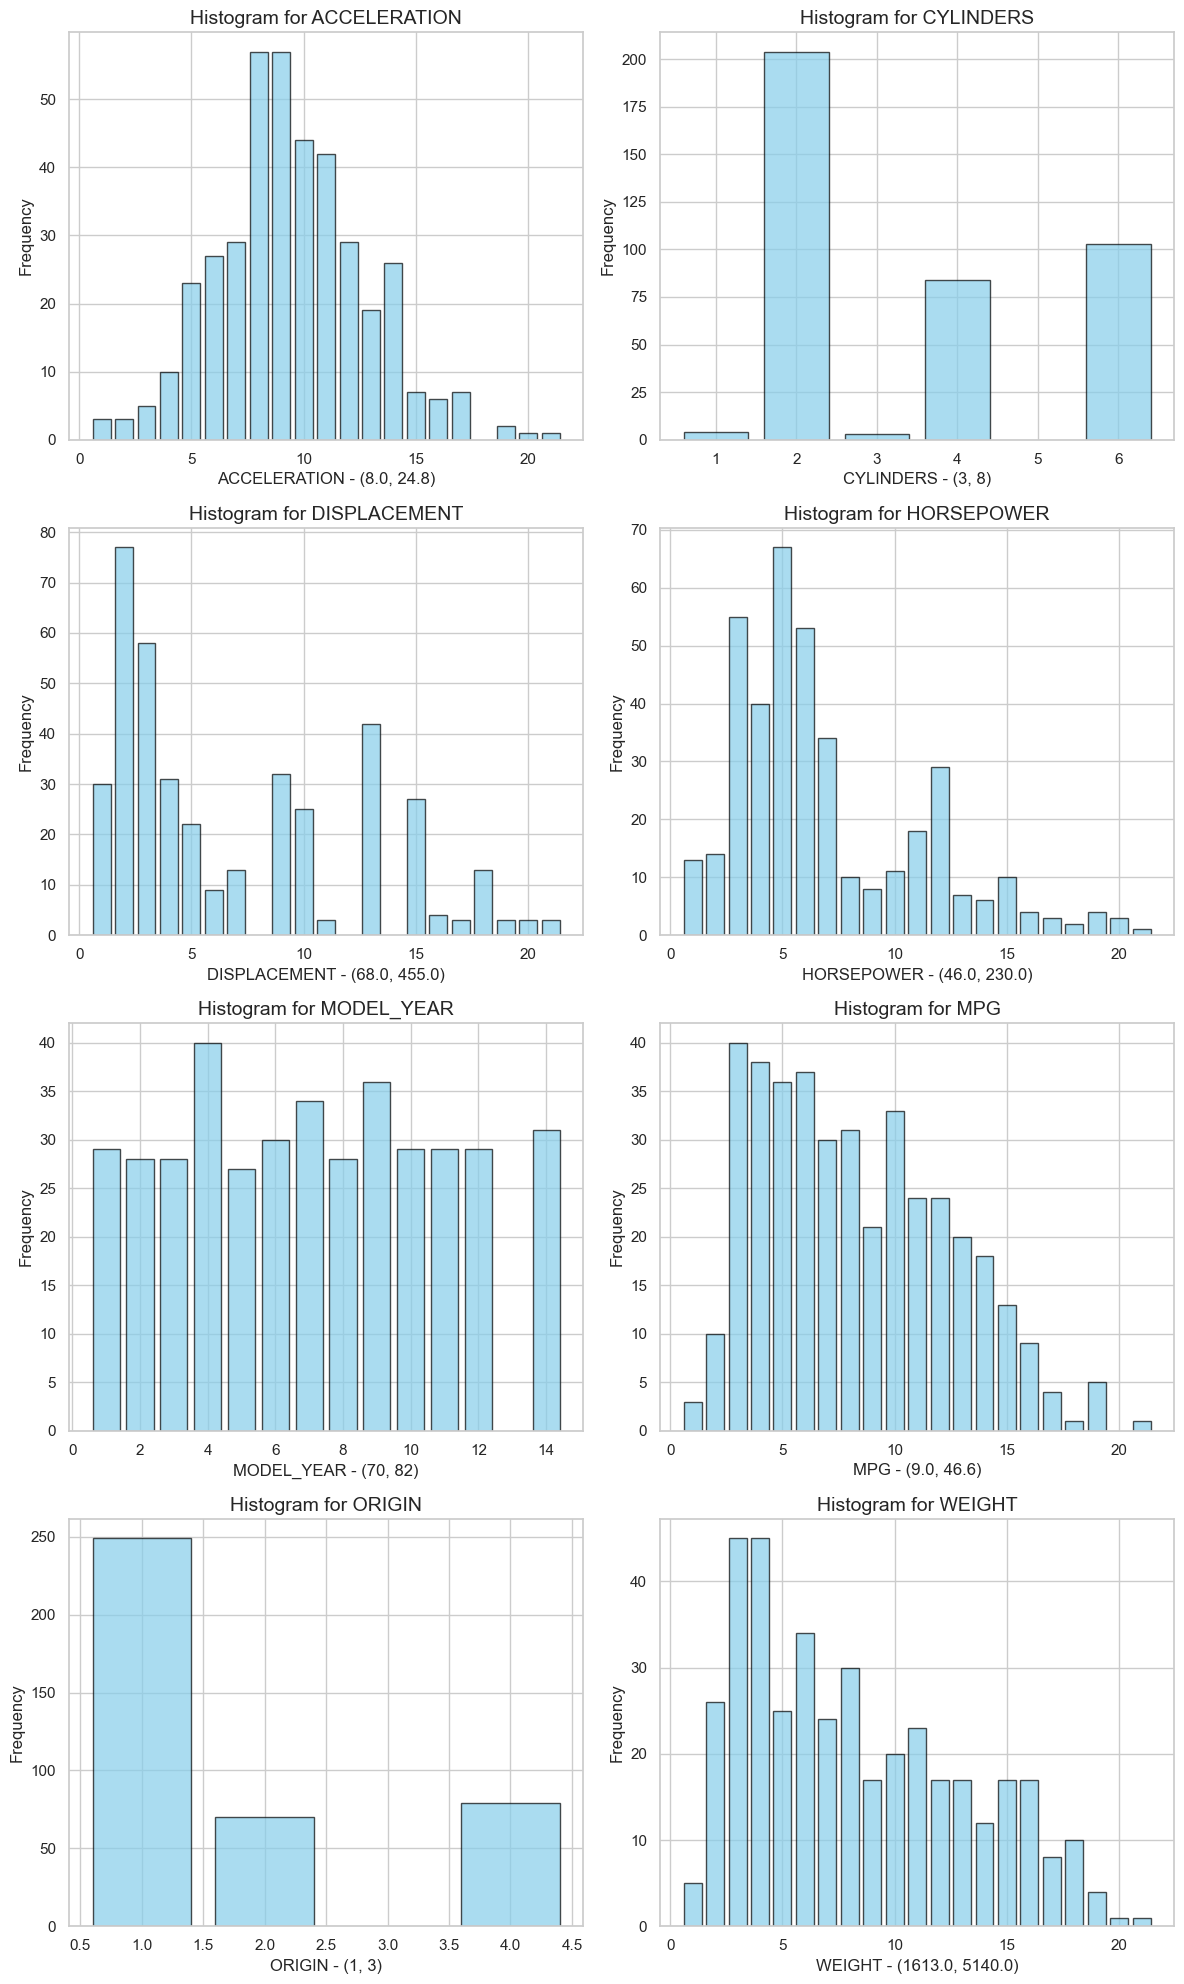

In [26]:
# Number of columns per row for subplot grid
num_columns = 2
num_rows = (len(columns) + num_columns - 1) // num_columns  # Calculate rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each column to calculate the histogram and plot
for i, column in enumerate(columns):
    # Raw SQL to get the min and max values for the column
    min_value = df.select(F.min(column)).collect()[0][0]
    max_value = df.select(F.max(column)).collect()[0][0]

    # Get the number of distinct values for the column
    distinct_values_count = df.select(F.countDistinct(column)).collect()[0][0]

    # Set the number of bins based on distinct values
    num_bins = min(distinct_values_count, 20)
    
    # Use Snowflake's WIDTH_BUCKET function in raw SQL to create bins
    query = f"""
        SELECT
            WIDTH_BUCKET({column}, {min_value}, {max_value}, {num_bins}) AS bin,
            COUNT(*) AS count
        FROM {table_name}
        GROUP BY bin
        ORDER BY bin
    """
    
    # Execute the raw SQL query to get the histogram data
    histogram_df = df.session.sql(query)
    
    # Select only the relevant columns (BIN and COUNT)
    bin_edges = histogram_df.select("BIN").to_pandas()["BIN"].values
    bin_counts = histogram_df.select("COUNT").to_pandas()["COUNT"].values
    
    # Plot the histogram using Matplotlib
    axes[i].bar(bin_edges, bin_counts, edgecolor="black", color="skyblue", alpha=0.7)

    # Set the title and labels
    axes[i].set_title(f"Histogram for {column}", fontsize=14)
    axes[i].set_xlabel(f"{column} - ({min_value}, {max_value})", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

# Hide any empty subplots (if columns are less than total slots)
for i in range(len(columns), len(axes)):
    axes[i].axis("off")

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

# Model

[source](https://github.com/Snowflake-Labs/sfguide-intro-to-machine-learning-with-snowflake-ml-for-python/blob/main/notebooks/2_sf_nb_snowflake_ml_model_training_inference.ipynb?_fsi=9lyuUpj8)

In [32]:
# Split the data into train and test sets
df_train, df_test = df.random_split([0.8, 0.2], seed=82)

# Save the train and test sets as Snowflake tables
df_train.write.mode("overwrite").save_as_table(f"{table_name}_TRAIN")
df_test.write.mode("overwrite").save_as_table(f"{table_name}_TEST")

# Define numeric columns for imputation and scaling
numeric_columns = ["DISPLACEMENT", "HORSEPOWER", "WEIGHT", "ACCELERATION"]
rest_columns = [col for col in df.columns if col not in numeric_columns]

# Compute mean for imputation (filling missing values)
means = df_train.select([F.mean(F.col(c)).alias(c) for c in numeric_columns]).to_pandas().iloc[0]

# Impute missing values with column means using coalesce
df_train_imputed = df_train.select(
    *[F.coalesce(F.col(c), F.lit(means[c])).alias(c) for c in numeric_columns], F.col("ID")
)
df_test_imputed = df_test.select(
    *[F.coalesce(F.col(c), F.lit(means[c])).alias(c) for c in numeric_columns], F.col("ID")
)

# Compute mean and stddev for scaling
mean_values = df_train_imputed.select([F.mean(F.col(c)).alias(c) for c in numeric_columns]).to_pandas().iloc[0]
stddev_values = df_train_imputed.select([F.stddev_pop(F.col(c)).alias(c) for c in numeric_columns]).to_pandas().iloc[0]

In [33]:
means_df = pd.DataFrame(list(mean_values.items()), columns=["column", "mean"])
stddev_df = pd.DataFrame(list(stddev_values.items()), columns=["column", "stddev"])

# Save these dataframes as Snowflake tables (ensure that these tables exist)
means_df_snowflake = sp_session.write_pandas(means_df, "TRAIN_MEANS", auto_create_table=True)
stddev_df_snowflake = sp_session.write_pandas(stddev_df, "TRAIN_STDDEVS", auto_create_table=True)

In [36]:
# Convert them into dictionaries
means = means_df_snowflake.to_pandas().set_index("column")["mean"].to_dict()

stddevs = stddev_df_snowflake.to_pandas().set_index("column")["stddev"].to_dict()

# Now standardize the data using the mean and stddev for each numeric column
df_train_standardized = df_train_imputed.select(
    *[
        ((F.col(c) - F.lit(means[c])) / F.lit(stddevs[c])).alias(c)
        for c in numeric_columns
    ], F.col("ID")
)

df_test_standardized = df_test_imputed.select(
    *[
        ((F.col(c) - F.lit(means[c])) / F.lit(stddevs[c])).alias(c)
        for c in numeric_columns
    ], F.col("ID")
)

df_train_transformed = df_train_standardized.join(
    df_train.select([F.col(c) for c in rest_columns]), how="inner", on=["ID"]
)

df_test_transformed = df_test_standardized.join(
    df_test.select([F.col(c) for c in rest_columns]), how="inner", on=["ID"]
)

In [39]:
df_train_transformed.drop("ID").write.mode("overwrite").save_as_table(f"{table_name}_TRAIN_PROCESSED")
df_test_transformed.drop("ID").write.mode("overwrite").save_as_table(f"{table_name}_TEST_PROCESSED")

In [40]:
df_train = sp_session.table(f"{table_name}_TRAIN_PROCESSED")
df_test = sp_session.table(f"{table_name}_TEST_PROCESSED")

In [41]:
df_train.describe().show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"                |"DISPLACEMENT"          |"HORSEPOWER"            |"WEIGHT"               |"ACCELERATION"          |"MPG"               |"CYLINDERS"         |"MODEL_YEAR"       |"ORIGIN"            |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |325.0               |325.0                   |325.0                   |325.0                  |325.0                   |325.0               |325.0               |325.0              |325.0               |
|mean       |192.670769          |-3.416070845000482e-17  |-6.593016730850929e-17  |4.116365368225581e-17  |3.4502315534504865e-16  

In [42]:
df_train.count()

325

In [43]:
# alter warehouse to speed up computation
sp_session.sql("ALTER WAREHOUSE ml_warehouse SET WAREHOUSE_SIZE=LARGE;").show()

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------



In [44]:
# Define input and output columns
INPUT_COLUMNS = [col for col in df_train.columns if col != "MPG"]
LABEL_COLUMNS = ["MPG"]
OUTPUT_COLUMNS = ["PREDICTED_MPG"]

# Define a more comprehensive parameter grid
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],  # Number of trees in the forest
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],  # Controls the step size at each iteration
    # "max_depth": [3, 5, 7, 9, 11],  # Maximum depth of the trees
    # "min_child_weight": [1, 3, 5, 7],  # Minimum sum of instance weight (Hessian) for a child
    # "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting trees
    # "colsample_bytree": [0.6, 0.7, 0.8, 1.0],  # Fraction of features used for each tree
    # "gamma": [0, 0.1, 0.3, 0.5],  # Regularization term for controlling overfitting
    # "reg_alpha": [0, 0.1, 1, 10],  # L1 regularization
    # "reg_lambda": [0, 0.1, 1, 10],  # L2 regularization
    # "scale_pos_weight": [1, 5, 10]  # Controls the balance of positive and negative weights
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    n_jobs=-1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=INPUT_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

In [45]:
grid_search.fit(df_train)

In [46]:
# alter warehouse to speed up computation
sp_session.sql("ALTER WAREHOUSE ml_warehouse SET WAREHOUSE_SIZE=XSMALL;").show()

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------



In [47]:
print(grid_search.to_sklearn().best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=3,
             num_parallel_tree=None, random_state=None, ...)


<Figure size 1000x600 with 0 Axes>

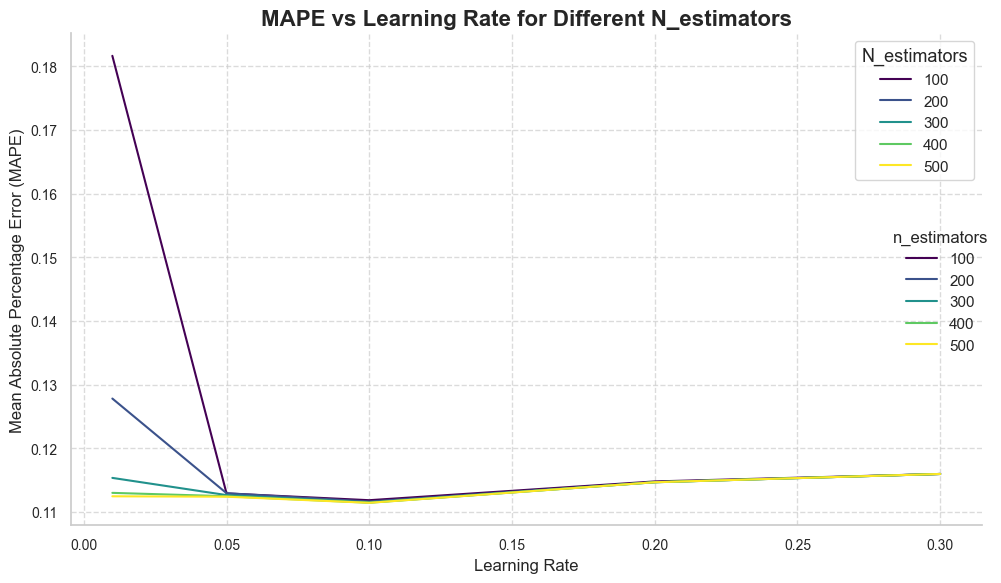

In [48]:
# Collect grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"] * -1

# Create a DataFrame for the results
gs_results_df = pd.DataFrame(data={
    "n_estimators": n_estimators_val,
    "learning_rate": learning_rate_val,
    "mape": mape_val})

# Create the plot
plt.figure(figsize=(10, 6))

# Advanced Seaborn plot with customized aesthetics
sns.set(style="whitegrid")
sns.relplot(
    data=gs_results_df,
    x="learning_rate",
    y="mape",
    hue="n_estimators",
    kind="line",
    markers=True,  # Add markers to each line point
    dashes=False,  # Remove dashed lines for a smoother look
    height=6,
    aspect=1.5,
    palette="viridis"  # Use a more refined color palette
)

# Customize the plot appearance
plt.title("MAPE vs Learning Rate for Different N_estimators", fontsize=16, weight="bold")
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Customize gridlines and add transparency
plt.grid(True, linestyle="--", alpha=0.7)

# Add a legend with a more refined look
plt.legend(title="N_estimators", title_fontsize="13", fontsize="11", loc="best")

# Show the plot
plt.tight_layout()  # Ensure everything fits well
plt.show()

In [49]:
result = grid_search.predict(df_test)

mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="MPG", 
                                        y_pred_col_names="PREDICTED_MPG")

result.select("MPG", "PREDICTED_MPG").show()
print(f"Mean absolute percentage error: {mape}")

------------------------------
|"MPG"  |"PREDICTED_MPG"     |
------------------------------
|22.0   |21.0128173828125    |
|25.0   |28.54265594482422   |
|14.0   |13.050567626953125  |
|13.0   |13.287660598754883  |
|26.0   |30.033050537109375  |
|21.0   |24.770952224731445  |
|15.0   |14.778676986694336  |
|23.0   |21.17877769470215   |
|13.0   |13.919239044189453  |
|18.0   |17.494932174682617  |
------------------------------

Mean absolute percentage error: 0.08480042665718988


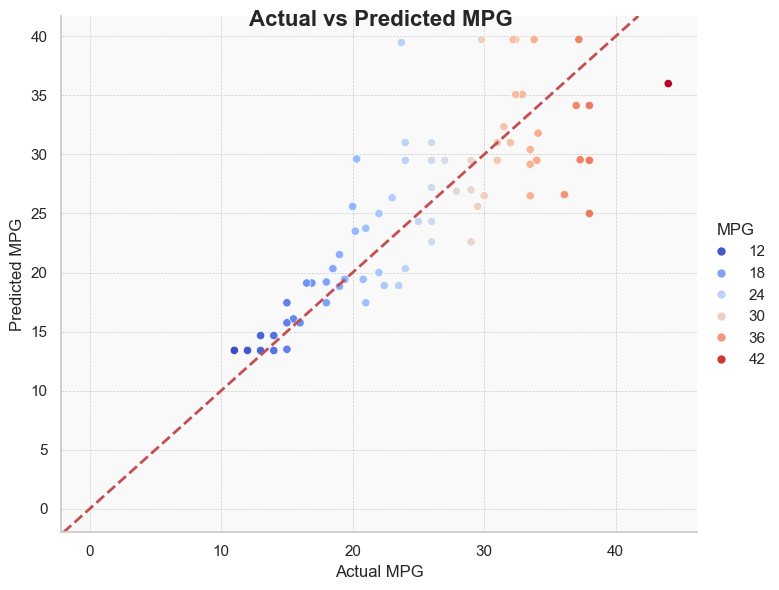

In [45]:
# Convert the data to float64 for better precision
data = result[["MPG", "PREDICTED_MPG"]].to_pandas().astype("float64")

# Create a scatter plot with seaborn
g = sns.relplot(data=data, x="MPG", y="PREDICTED_MPG", kind="scatter", hue="MPG", palette="coolwarm", height=6, aspect=1.2)

# Add a red line with slope 1 (identity line)
g.ax.axline((0, 0), slope=1, color="r", linestyle="--", linewidth=2)

# Add title and axis labels
g.set_axis_labels("Actual MPG", "Predicted MPG")
g.fig.suptitle("Actual vs Predicted MPG", fontsize=16, fontweight="bold")

# Adjust gridlines and aesthetics
g.ax.grid(True, which='both', linestyle='--', linewidth=0.5)
g.ax.set_facecolor('#f9f9f9')  # Light gray background
g.ax.spines['top'].set_visible(False)
g.ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

In [50]:
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_score = grid_search.to_sklearn().best_score_

In [51]:
grid_search.to_sklearn().cv_results_['mean_test_score']

array([-0.1816477 , -0.12781309, -0.11534962, -0.11299808, -0.11246089,
       -0.11290907, -0.11294508, -0.11264918, -0.11246738, -0.11239691,
       -0.11184571, -0.11163733, -0.1114932 , -0.11144906, -0.11143427,
       -0.11479397, -0.11468302, -0.11466586, -0.11466586, -0.11466586,
       -0.11596546, -0.11596771, -0.11596771, -0.11596771, -0.11596771])

In [54]:
# Get sample input data to pass into the registry logging function
X = df_train.drop("MPG").limit(100)

db = identifier._get_unescaped_name(sp_session.get_current_database())
schema = identifier._get_unescaped_name(sp_session.get_current_schema())

model_name = "MPG_PREDICTION"

# Create a registry and log the model
native_registry = Registry(session=sp_session, database_name=db, schema_name=schema)
native_registry.delete_model(model_name)

# Let's first log the very first model we trained
model_ver = native_registry.log_model(
    model_name=model_name,
    version_name='V0',
    model=optimal_model,
    sample_input_data=X, # to provide the feature schema
    options={"enable_explainability": True}
)

# Add evaluation metric
model_ver.set_metric(metric_name="neg_mean_absolute_percentage_error", value=optimal_score)

# Add a description
model_ver.comment = "This is the first iteration of our MPG Prediction model. It is used for demo purposes."

/opt/homebrew/Caskroom/miniconda/base/envs/snowpark-ml/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:69: UserWarning: The sample input has 100 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/snowpark-ml/lib/python3.11/site-packages/snowflake/ml/model/_model_composer/model_composer.py:130: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  self.manifest.save(


In [55]:
native_registry.get_model(model_name).show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data
0,2025-01-04 12:10:56.873000-08:00,V0,"[""DEFAULT"",""FIRST"",""LAST""]",This is the first iteration of our MPG Predict...,ML_DATABASE,DATASETS,MPG_PREDICTION,true,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""neg_mean_absolute_percentage_err...",{}


In [56]:
model_ver = native_registry.get_model(model_name).version('v0')

In [62]:
model_ver.run(df_train, function_name="predict").select("MPG", '"output_feature_0"').show()

------------------------------
|"MPG"  |"output_feature_0"  |
------------------------------
|18.0   |17.998979568481445  |
|15.0   |15.000691413879395  |
|18.0   |17.995084762573242  |
|16.0   |16.005020141601562  |
|17.0   |16.999452590942383  |
|15.0   |14.99695110321045   |
|14.0   |14.005260467529297  |
|14.0   |14.001791000366211  |
|14.0   |13.993114471435547  |
|15.0   |14.99509334564209   |
------------------------------



In [63]:
mv_explanations = model_ver.run(df_train, function_name="explain")

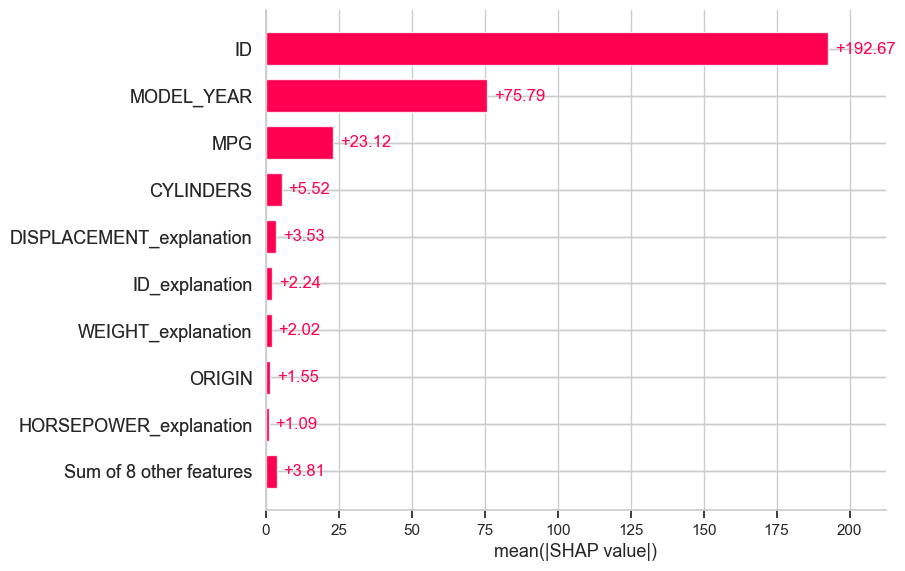

In [64]:
mv_explanations_pd = mv_explanations.to_pandas()
# Wrapping the explanations DataFrame into a SHAP recognized object
shap_exp = shap._explanation.Explanation(mv_explanations_pd.values, 
                                         feature_names = mv_explanations_pd.columns)
shap.plots.bar(shap_exp)